# Machine Learning - SF vs NYC Housing 
#### Going Down the EECS Stack DeCal Spring 2017
#### Data courtesy of [r2d3](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)

In this notebook, we'll explore some ideas behind machine learning using housing data from San Francisco and New York. </br>
Each data point corresponds to a house with the following fields:
- year_build (int, e.g. 1990)
- price_per_sqft (int, dollars)
- bath (float)
- beds (float)
- elevation (int, ft)
- price (int, dollars)
- in_sf (int, 1 if in sf, 0 otherwise)

In the first part of this notebook we'll try to classify houses and predict whether a house is from NYC or SF. In the second part we'll try to regress and predict the prices of the houses.

<br />
Mathy Notation for later parts:
- $n$ denotes the number of data points (houses) 
- $d$ denotes the number of features 
- $X$ is an $n \times d$ matrix, where each row corresponds to a house. $X_i$ means the $i$th row, or the $i$th feature vector.
- $y$ is a length $n$ vector, where each index corresponds to a label. $y_i$ means the label for the $i$th house. For part 1 the labels are either $1$ or $0$ for SF and NYC respectively. For part 2 the labels are real numbers denoting housing price.


In [1]:
# imports
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from csv import DictReader
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from IPython.display import clear_output
from time import sleep
import sys

In [2]:
# loading housing data
all_data = []
with open('housing.csv', 'r') as f:
    reader = DictReader(f)
    for row in reader:
        all_data.append({
                'year_built': int(row['year_built']),
                'price_per_sqft': int(row['price_per_sqft']),
                'bath': float(row['bath']),
                'beds': float(row['beds']),
                'elevation': int(row['elevation']),
                'price': int(row['price']),
                'in_sf': int(row['in_sf'])
            })
# shuffling data
np.random.shuffle(all_data)

In [3]:
# separating features from labels for classification exercises
features_c = []
labels_c = []
for data in all_data:
    data = data.copy()
    labels_c.append(data.pop('in_sf', None))
    features_c.append(data)

In [4]:
# separating features from labels for regression exercises
features_r = []
labels_r = []
for data in all_data:
    data = data.copy()
    labels_r.append(data.pop('price', None))
    features_r.append(data)

## Part 1: Classification: NYC vs SF
<img src="https://grapecollective.com/media/article/image/cache/720x337-center/c/o/comparison.jpg">

### Part 1.1 Manual Classification
1. Use the cell below to explore statistics about the housing data. You can look for things such as "average elevation of houses in SF" vs "average elevation of houses in NY".
2. Use your knowledge about the data to fill in the function "is_in_sf," which takes in a feature dictionary and returns 1 if you think this house belongs in SF, 0 if it belongs to NY
3. Test how good your result is. Try to improve your score as much as possible!

In [5]:
# 1) explore the data
def query(in_sf, feature_name, statistic):
    '''
    in_sf is either 1 or 0
    statistic is either 'mean', 'std', 'min', 'max'
    feel free to modify this function to explore other properties about the housing data.
    '''
    if in_sf not in (0, 1):
        raise ValueError("Location can only be 0 for nyc or 1 for sf!")
    if feature_name not in features_c[0]:
        raise ValueError("Invalid feature_name!")
    if statistic not in ('mean', 'std', 'max', 'min'):
        raise ValueError("Statistic can only be 'mean', 'std', 'min', 'max'")
    
    col = []
    for data in all_data:
        if data['in_sf'] == in_sf:
            col.append(data[feature_name])
    
    statistics_map = {
        'min': np.min,
        'max': np.max,
        'mean': np.mean,
        'std': np.std
    }
    
    return statistics_map[statistic](col)
    
print "The mean elevation of houses in NYC is", query(0, 'elevation', 'mean')
print "The mean elevation of houses in SF is", query(1, 'elevation', 'mean')

The mean elevation of houses in NYC is 13.5044642857
The mean elevation of houses in SF is 61.8619402985


In [6]:
# 2) fill in is_in_sf
def is_in_sf(feature):
    '''
    feature is a dictionary with the following keys: 
    - 'year_built'
    - 'price_per_sqft'
    - 'bath'
    - 'beds'
    - 'elevation'
    - 'price'
    
    return 1 if house is predicted to be in SF, 0 if NYC
    '''
    ### Your Code Below ###
    # SAMPLE CODE #
    if feature['elevation'] > 30:
        return 1
    else:
        0

In [7]:
# 3) Test your performance!
num_correct = 0
sf_but_pred_ny = 0
total_num = len(features_c)
for i, feature in enumerate(features_c):
    prediction_in_sf = is_in_sf(feature)
    if prediction_in_sf == labels_c[i]:
        num_correct += 1
    else:
        if labels_c[i] and not prediction_in_sf:
            sf_but_pred_ny += 1
print "Got {0:.2f}% correct!".format(num_correct/1./total_num*100)
print "Out of incorrect predictions, {0:.2f}% were SF houses predicted to be in NYC".format(
                                                                                sf_but_pred_ny/1./(total_num - num_correct)*100)

Got 37.20% correct!
Out of incorrect predictions, 27.51% were SF houses predicted to be in NYC


### Part 1.2 The Perceptron Algorithm

In this section we will implement the perceptron algorithm, which will learn a linear decision boundary function $f(x)$ of the form:
$$
f(X_i) = \left\{
        \begin{array}{ll}
            1 & \quad w^\top X_i + b > 0 \\
            0 & \quad else
        \end{array}
    \right.
$$
You can think of this function as drawing a line in the feature space. If a data point is above this line, we'll say it's from SF. If a data point is below this line, we'll say it's from NYC. In the 1D case where there is only 1 feature used, $w$ would be the slope of the line, and $b$ the y-intercept.

<br />

Note that $f$ is *parameterized* by $w$ and $b$. So our goal is to find the $w$ and $b$ that best minimizes a *loss* function:
$$
L(X, y) = \frac{1}{N} \sum_{i=1}^{N} |f_{w, b}(X_i) - y_i|
$$

<br />
The perceptron algorithm has 2 *hyperparameters*: the learning rate and the number of epochs to be trained on. In addition, we can also select a smaller set of features instead of using all of them to learn on (sometimes this performs better). Complete the steps below:
1. Understand the perceptron algorithm implementation
2. Experiment w/ learning rate and epochs. How do these affect the train and test performance? Why?
3. Experiment w/ feature selection. Which features seem to work the best? Why?
4. Tweak the above settings to get the best test performance. 
5. If you used 2 or 3 features, you can run the visualization code to visualize the decision boundary.

In [62]:
# helper functions. can ignore these
def features_dict_to_np_array(features):
    X = []
    for feature in features:
        X.append([val for val in feature.values()])
    return np.array(X)

def extract_cols(lst, keys):
    new_lst = []
    for i, d in enumerate(lst):
        row = []
        for key in keys:
            row.append(d[key])
        new_lst.append(row)
    
    return np.array(new_lst)

def f(w, b, x):
    if w.dot(x) + b > 0:
        return 1
    else:
        return 0
    
def classification_accuracy(X, y, w, b):
    y_pred = [f(w, b, x) for x in X]
    return (1 - mean_absolute_error(y_pred, y))*100

def regression_mae(X, y, w, b):
    y_pred = X.dot(w) + b
    return mean_absolute_error(y_pred, y)

def visualize_perceptron(feature_names, X, y, w, b):
    d = len(feature_names)
    if d not in (2, 3):
        print "Visualize 2d can only take 2 or 3 features at once!"
        return
    
    is_sf = np.where(y == 1)
    is_nyc = np.where(y == 0)
    
    X_sf = np.take(X, is_sf, axis=0).reshape(-1, d)
    X_nyc = np.take(X, is_nyc, axis=0).reshape(-1, d)
    
    # visualize 2d
    if d == 2:
        fig = plt.figure()
        ax = fig.gca()
        
        h_min, h_max = X[:,0].min(), X[:,0].max()
        m = w[1]/w[0]
        ax.plot([h_min, h_max], [b, b + m*(h_max - h_min)], '-', label='decision boundary')
        v_min, v_max = X[:,1].min(), X[:,1].max()        
        
        ax.scatter(X_sf[:,0], X_sf[:,1], label='sf', c='red')
        ax.scatter(X_nyc[:,0], X_nyc[:,1], label='nyc')
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
        plt.legend()
        plt.xlim(h_min, h_max)
        plt.ylim(v_min, v_max)
        plt.title("Visualization of Housing SF vs NYC Classification")
        plt.show()        
        
    # visualize 3d
    elif d == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        ax.scatter(X_sf[:,0], X_sf[:,1], X_sf[:,2], c='r', label='sf')
        ax.scatter(X_nyc[:,0], X_nyc[:,1], X_nyc[:,2], c='b', label='nyc')
        
        xx_min, xx_max = X[:,0].min(), X[:,0].max()
        yy_min, yy_max = X[:,1].min(), X[:,1].max()
        
        xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 2), np.linspace(yy_min, yy_max, 2))
        z = (-w[0] * xx -w[1] * yy - b) /1./ w[2]        
        
        ax.plot_surface(xx, yy, z, label='decision boundary', alpha=0.2)
        ax.set_xlabel(feature_names[2])
        ax.set_ylabel(feature_names[1])
        ax.set_zlabel(feature_names[0])
        plt.title("Visualization of Housing SF vs NYC Classification")
        fig.show()
        
def visualize_linear_regression(feature_names, X, y, w, b):
    d = len(feature_names)
    
    if d not in (1, 2):
        print "Can only visualize 1 or 2 features at a time."
        return 
    
    if d == 1:
        x_min, x_max = X.min(), X.max()
        
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(X.reshape(-1,1), y)
        plt.plot([x_min, x_max], [b, b + w*(x_max - x_min)], '-', label='prediction')
        plt.xlabel(feature_names[0])
        plt.ylabel("Price")
        plt.legend()
        plt.title("Visualization of Housing Price Regression")
        fig.show()
        
    elif d == 2:
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        ax.scatter(X[:,0], X[:,1], y)
        
        xx_min, xx_max = X[:,0].min(), X[:,0].max()
        yy_min, yy_max = X[:,1].min(), X[:,1].max()
        
        xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 2), np.linspace(yy_min, yy_max, 2))
        z = w[0] * xx + w[1] * yy + b 
        
        ax.plot_surface(xx, yy, z, alpha=0.2)
        ax.set_xlabel(feature_names[0])
        ax.set_ylabel(feature_names[1])
        ax.set_zlabel("Price")
        plt.title("Visualization of Housing Price Regression")
        fig.show()      

In [9]:
# 1) Read this implementation. Try matching it with the pseudocode
def perceptron_learn_w_b(X_tr, y_tr, X_t, y_t, epochs, learning_rate):
    '''
    Run the perceptron algorithm for epochs iterations
    Return w, b
    '''
    # dimensions
    N = X_tr.shape[0] # number of data points we have
    d = X_tr.shape[1] # dimension of a feature vector
    
    # initialize weights
    w = np.zeros(d) # a vector of 0's of size d
    b = 0 # bias starts at 0
    
    # perceptron learning algorithm
    for t in range(epochs):
        for i in range(N):            
            x = X_tr[i]
            pred_y = f(w, b, x)
            error = y_tr[i] - pred_y
            
            # TODO: HIDE THIS FOR IMPLEMENTATION??
            b = b + learning_rate * error
            w = w + learning_rate * error * x
        
        # reporting accuracy
        train_accuracy = classification_accuracy(X_tr, y_tr, w, b)
        test_accuracy = classification_accuracy(X_t, y_t, w, b)
        clear_output(wait=True)
        print 'epoch={}/{}'.format(t+1, epochs), 'train={0:.2f}%'.format(train_accuracy), 'test={0:.2f}%'.format(test_accuracy)
                
    return w, b

In [10]:
# 2) Choose hyperparameters
epochs = 100
learning_rate = 1

In [11]:
# 3) Choose which features to use
# available features are 'year_built', 'price_per_sqft', 'bath', 'beds', 'elevation', 'price'
features_to_use_c = ['elevation', 'price_per_sqft']#, 'bath', 'beds', 'elevation', 'price']

In [12]:
# 4) Run this cell to train perceptron!
index_train_split = int(0.8 * len(features_c))
features_c_small = extract_cols(features_c, features_to_use_c)
features_c_train_array, features_c_test_array = features_c_small[:index_train_split], features_c_small[index_train_split:]
labels_c_train_array, labels_c_test_array = np.array(labels_c[:index_train_split]), np.array(labels_c[index_train_split:])

w_c, b_c = perceptron_learn_w_b(features_c_train_array, labels_c_train_array, features_c_test_array, labels_c_test_array, 
                            epochs, learning_rate)
print 'w is ', w_c, 'b is ', b_c

epoch=100/100 train=80.66% test=87.88%
w is  [ 35452.  -1161.] b is  1763


<IPython.core.display.Javascript object>


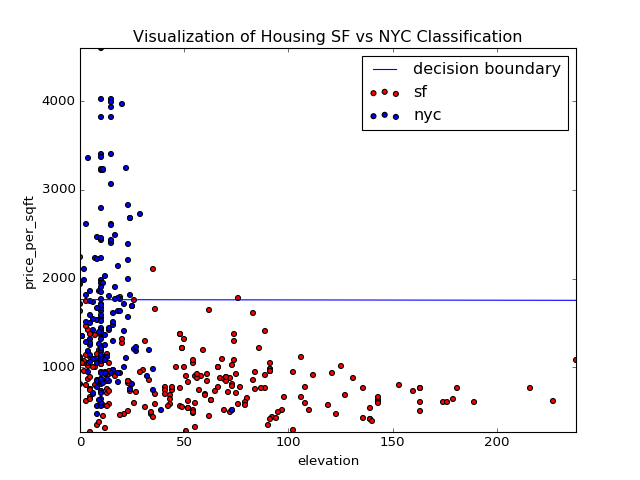

In [63]:
# 5) visualize data and learned decision boundary
visualize_perceptron(features_to_use_c, features_c_train_array, labels_c_train_array, w_c, b_c)

## Part 2 Regression on Housing Price

In this section, our goal is to learn a model that predicts house prices. Our label is now "price" instead of "in_sf." "in_sf" is now included as a feature.

## Part 2.1 Linear Regression for Expected House Price

In linear regression, we use a linear function to map from input features to output labels. Similar to the perceptron algorithm above, this model has the form:
$$
y_i = w^\top X_i + b
$$
The new $f$ for regression which outputs the predicted $y$ values will be:
$$
f(X) = Xw + B
$$
Where $B$ is a length $n$ vector, and every single value is $b$. Our loss function will be the same as above:
$$
L(X, y) = \frac{1}{N} \sum_{i=1}^{N} |f_{w, b}(X_i) - y_i|
$$

Complete the steps below:
1. Implement Linear Regression using $b$ as the mean of $y$ and $w$ the pseudoinverse of $X$
2. Experiment with which features to use to get the best performance
3. Run Linear Regression. Observe results. MAE stands for Mean Absolute Error. 
4. Visualize the linear regression line for when using only 1 feature or 2 features.
5. Are the results good or bad? Why?

In [14]:
# 1) Implement Linear Regression
def linear_regression(X_tr, y_tr, X_t, y_t):
    '''
    return weight vector w and bias b
    '''
    # TODO: ERASE FOR IMPLEMENTATION?
    b = y_tr.mean()
    
    w = np.linalg.inv(X_tr.T.dot(X_tr)).dot(X_tr.T).dot(y_tr - b)
    
    train_mae = regression_mae(X_tr, y_tr, w, b)
    test_mae = regression_mae(X_t, y_t, w, b)
    
    print "Train MAE {}".format(train_mae), "Test MAE {}".format(test_mae)   
    
    return w, b

In [59]:
# 2) Choose which features to use
features_to_use_r = ['price_per_sqft', 'year_built']#year_built', 'price_per_sqft', 'bath', 'beds', 'elevation', 'in_sf']

In [60]:
# 3) Run this cell to run linear regression
index_train_split = int(0.8 * len(features_r))
features_r_small = extract_cols(features_r, features_to_use_r)
features_r_train_array, features_r_test_array = features_r_small[:index_train_split], features_r_small[index_train_split:]
labels_r_train_array, labels_r_test_array = np.array(labels_r[:index_train_split]), np.array(labels_r[index_train_split:])

w_r, b_r = linear_regression(features_r_train_array, labels_r_train_array, features_r_test_array, labels_r_test_array)
print 'w is ', w_r, 'b is ', b_r

Train MAE 1123891.50124 Test MAE 1057195.35085
w is  [ 2951.14615534 -1818.36697248] b is  2028795.56489


<IPython.core.display.Javascript object>


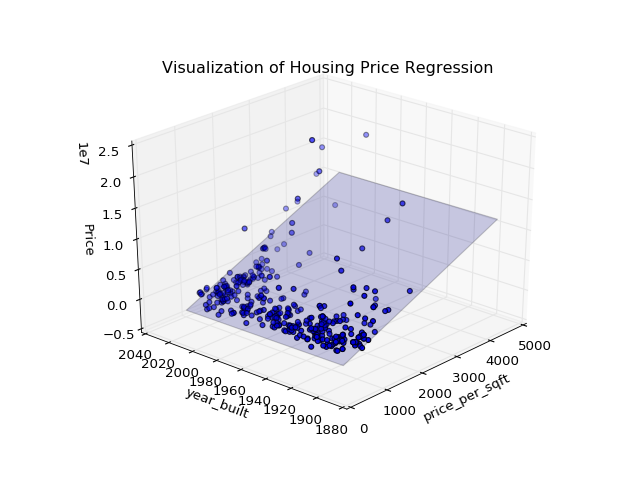

In [61]:
# 5) Visualize linear predictor for 1 or 2 features
visualize_linear_regression(features_to_use_r, features_r_train_array, labels_r_train_array, w_r, b_r)